In [41]:
import pandas as pd
import numpy as np
import plotly.express as ex
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import accuracy_score,f1_score, recall_score,precision_score,confusion_matrix,roc_auc_score, mean_squared_error,mean_absolute_percentage_error
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

In [42]:
###Importing dataset
df=pd.read_csv('credit_risk.csv')
target = 'Credit_Status'

In [43]:
###Quick view of dataset
def overview_df(dataFrame):
    print("##########Shape###########")
    print(df.shape)
    print("##########Info###########")
    print(df.info())
    print("##########Head###########")
    print(df.head())
    print("##########Columns#########")
    print(df.columns)
    print("##########Types###########")
    print(df.dtypes)
    print("##########NA###########")
    print(df.isnull().sum())
    print("##########For Numerics########")
    print(df.describe().T)
overview_df(df)

##########Shape###########
(32581, 12)
##########Info###########
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    32581 non-null  int64  
 1   salary                 32581 non-null  int64  
 2   home_ownership         32581 non-null  object 
 3   employment_time        31686 non-null  float64
 4   loan_purposes          32581 non-null  object 
 5   credit_score           32581 non-null  object 
 6   Credit_Amount          32581 non-null  int64  
 7   loan_rate              29465 non-null  float64
 8   Credit_Status          32581 non-null  int64  
 9   loan_percentage        32581 non-null  float64
 10  Payment_History        32581 non-null  object 
 11  Credit_History_Length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None
##########Head###########
   ag

### BUSINESS UNDERSTANDING & TARGET ANALYSIS

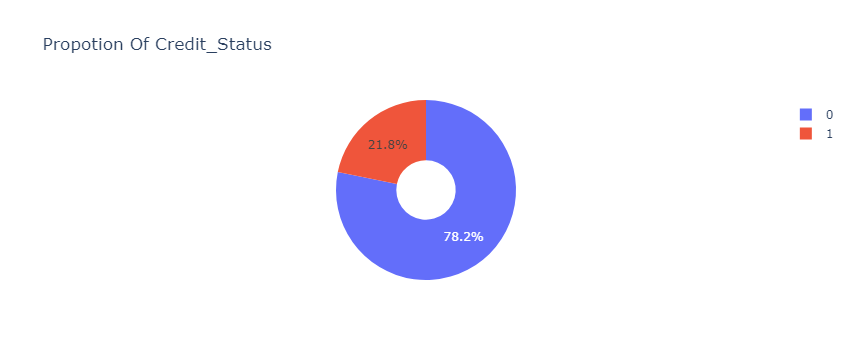

In [44]:
#Create pie to understand proporsions of target value
ex.pie(df,names='Credit_Status',title='Propotion Of Credit_Status',hole=0.33)

In [45]:
#Correlation between other columns and target
cor_target = df.corrwith(df["Credit_Status"])
cor_target


age                     -0.021629
salary                  -0.144449
employment_time         -0.082489
Credit_Amount            0.105376
loan_rate                0.335133
Credit_Status            1.000000
loan_percentage          0.379366
Credit_History_Length   -0.015529
dtype: float64

### DATA UNDERSTANDING & DATA PREPERATION

In [46]:
#Replacing cat columns
df['credit_score'].value_counts()
credit_range = {
    'A': 825,
    'B': 775,
    'C': 725,
    'D': 675,
    'E': 625,
    'F': 575,
    'G': 525
}

df['credit_score'] = df['credit_score'].map(credit_range)


df['Payment_History'] = df['Payment_History'].map({'Y': 1, 'N':0})



In [47]:
#Creating new column to get higher corr and better learning of model
df['creditAmount_loanPer'] = df['loan_percentage'] * df['Credit_Amount']

numeric_cols=df.select_dtypes(exclude='object')
categoric_cols=df.select_dtypes(include='object')

numeric_columns_with_target=list(numeric_cols)
numeric_columns_with_target.append('Credit_Status')


<Axes: >

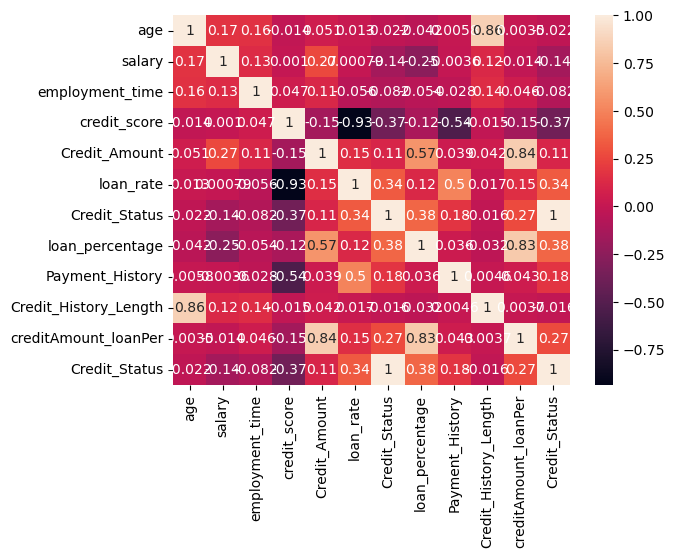

In [48]:
sns.heatmap(df[numeric_columns_with_target].corr(),annot=True)

<Axes: >

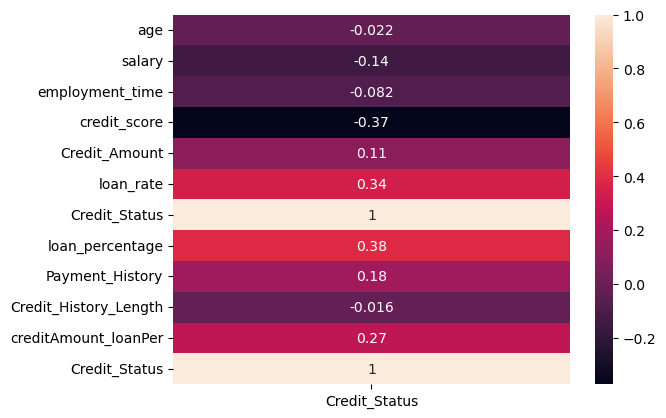

In [49]:
sns.heatmap(df[numeric_columns_with_target].corr().iloc[:,[-1]],annot=True)

In [50]:
#Credit_History_Length and age columns are correlated by 86%
df = df.drop('Credit_History_Length', axis = 1)

In [51]:
categoric_cols

,home_ownership,loan_purposes
0,RENT,EDUCATION
1,RENT,MEDICAL
2,MORTGAGE,HOMEIMPROVEMENT
3,RENT,MEDICAL
4,MORTGAGE,DEBTCONSOLIDATION
...,...,...
32576,OWN,PERSONAL
32577,RENT,VENTURE
32578,RENT,DEBTCONSOLIDATION
32579,MORTGAGE,VENTURE


In [52]:
###CHI-SQUARE testing to determine if there is any significant relation between cat columns or not
###Results are significant, this means we can include these variables in modelling phase to get proper output
# Create a contingency table             
contingency_table = pd.crosstab(df['home_ownership'], df['Credit_Status'])

# Perform chi-square test
chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)

# Print the results
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)


contingency_table1 = pd.crosstab(df['loan_purposes'], df['Credit_Status'])
chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table1)
print("Chi-square statistic1:", chi2_stat)
print("P-value1:", p_value)



#One Hot encoding 
df = pd.get_dummies(df, columns=['home_ownership'], prefix='home')
df = pd.get_dummies(df, columns=['loan_purposes'], prefix='loan')



Chi-square statistic: 1907.980698188821
P-value: 0.0
Chi-square statistic1: 520.5115614374077
P-value1: 2.980681669776041e-110


In [53]:
df.head()

,age,salary,employment_time,credit_score,Credit_Amount,loan_rate,Credit_Status,loan_percentage,Payment_History,creditAmount_loanPer,home_MORTGAGE,home_OTHER,home_OWN,home_RENT,loan_DEBTCONSOLIDATION,loan_EDUCATION,loan_HOMEIMPROVEMENT,loan_MEDICAL,loan_PERSONAL,loan_VENTURE
0,23,70000,3.0,825,12000,7.90,0,0.17,0,2040.0,0,0,0,1,0,1,0,0,0,0
1,25,25000,0.0,725,8500,12.53,1,0.34,1,2890.0,0,0,0,1,0,0,0,1,0,0
2,24,67000,2.0,775,12150,10.37,0,0.18,0,2187.0,1,0,0,0,0,0,1,0,0,0
3,23,69000,7.0,825,6000,7.88,0,0.09,0,540.0,0,0,0,1,0,0,0,1,0,0
4,30,33000,2.0,825,6000,8.49,0,0.18,0,1080.0,1,0,0,0,1,0,0,0,0,0


In [54]:
df.isnull().sum()

age                          0
salary                       0
employment_time            895
credit_score                 0
Credit_Amount                0
loan_rate                 3116
Credit_Status                0
loan_percentage              0
Payment_History              0
creditAmount_loanPer         0
home_MORTGAGE                0
home_OTHER                   0
home_OWN                     0
home_RENT                    0
loan_DEBTCONSOLIDATION       0
loan_EDUCATION               0
loan_HOMEIMPROVEMENT         0
loan_MEDICAL                 0
loan_PERSONAL                0
loan_VENTURE                 0
dtype: int64

In [55]:
#HANDLING NULL VALUES
#Dataset is normally distributed, thats why lets drop null values
df.dropna(subset=['employment_time', 'loan_rate'], inplace=True)
df.isnull().sum()

age                       0
salary                    0
employment_time           0
credit_score              0
Credit_Amount             0
loan_rate                 0
Credit_Status             0
loan_percentage           0
Payment_History           0
creditAmount_loanPer      0
home_MORTGAGE             0
home_OTHER                0
home_OWN                  0
home_RENT                 0
loan_DEBTCONSOLIDATION    0
loan_EDUCATION            0
loan_HOMEIMPROVEMENT      0
loan_MEDICAL              0
loan_PERSONAL             0
loan_VENTURE              0
dtype: int64

<Axes: >

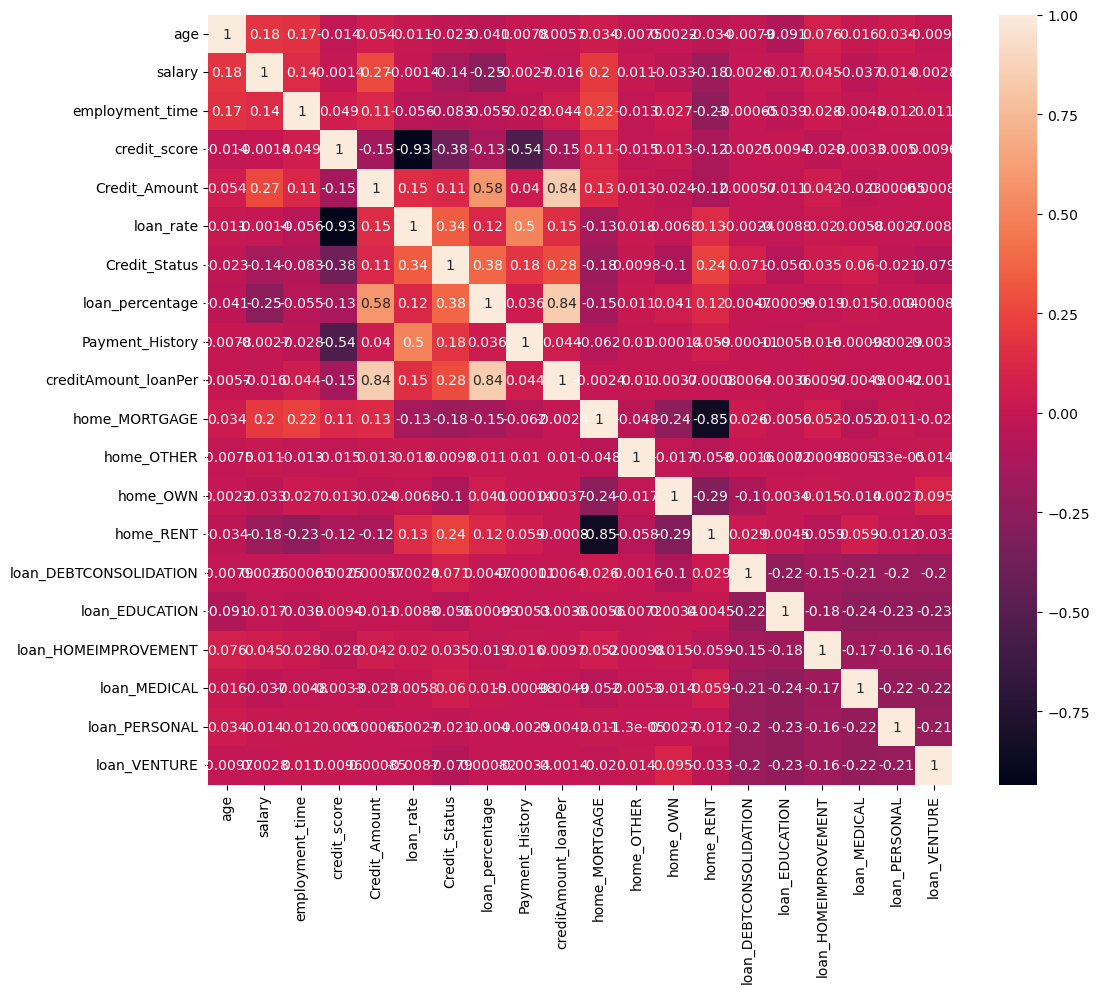

In [56]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(),annot=True)


### MODELLING

In [57]:
#Split dataset
x = df.drop( ['Credit_Status'], axis = 1 )
y = df[['Credit_Status']]

X_train, X_test, y_train, y_test = train_test_split(x,y ,random_state=104, test_size=0.25, shuffle=True)

In [58]:
clf = tree.DecisionTreeClassifier() 
clf.fit(X_train, y_train)

DecisionTreeClassifier()

Confusion Matrix:
[[5157  387]
 [ 392 1224]]


<Axes: >

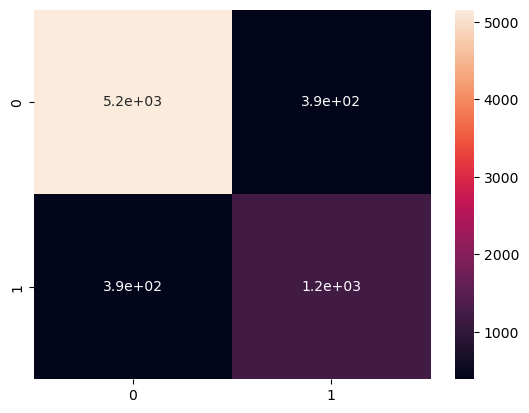

In [59]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True)


<Axes: >

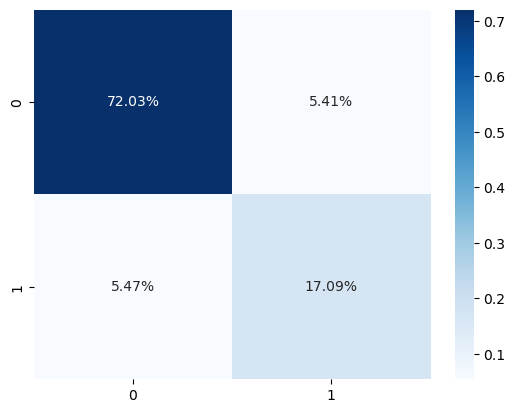

In [60]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

In [61]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8912011173184358


In [62]:
recall_score = recall_score(y_test, y_pred)
print("recall_score:", recall_score)

recall_score: 0.7574257425742574


In [63]:
precision_score = precision_score(y_test, y_pred)
print("precision_score:", precision_score)

precision_score: 0.7597765363128491


In [64]:
# Calculate the f1_score of the model
f1score = f1_score(y_test, y_pred)
print("f1_score:", f1score)

f1_score: 0.7585993182522467


### MSE & MAPE

In [65]:
#Calculate the MAPE of the model
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

MSE: 0.10879888268156425


In [66]:
#Calculate the MAPE of the model
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

MAPE: 243420817848098.03
